In [1]:
import urllib.request
from bs4 import BeautifulSoup
import re
import numpy as np
import datetime
import unicodedata
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from matplotlib.ticker import ScalarFormatter
import random
import json
import glob

from tqdm import tqdm_notebook as tqdm
from ipywidgets import IntProgress

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

def GetBinsData(string, dataset):
    hoge = [i[string] for i in dataset]
    return hoge

### スクレイピングで取得したデータを読み込む

In [2]:
dataset = np.load('typhoon/dataset.npy')
dic_array  = dataset[0]

###  全ての台風の取得したデータを可視化

In [15]:
year_range = np.arange(1978,2020,1)
attrs_list = ['pressure','wind_velocity','area1','area2','moving',
              'mean_velocity','ACE']
dataset_lim = []
range_list = []
for n in range(year_range.shape[0]-1):
    range_ = np.linspace(year_range[n]+1,year_range[n+1],5)
    range_list.append(range_.astype(np.uint32))
    name = str(int(range_[0]))+'-'+str(int(range_[-1]))
    attrs = {'pressure':[], 'wind_velocity':[], 'area1':[],
                'area2':[], 'moving':[], 'mean_velocity':[],
                'ACE':[],'amount':[]}
    for y in range_:
        typhoon_list = dic_array[str(int(y))]
        attrs['amount'].append(len(typhoon_list))
        for t in typhoon_list:
            for a in attrs_list:
                attrs[a].append(t[a])
    
    dataset_lim.append(attrs)

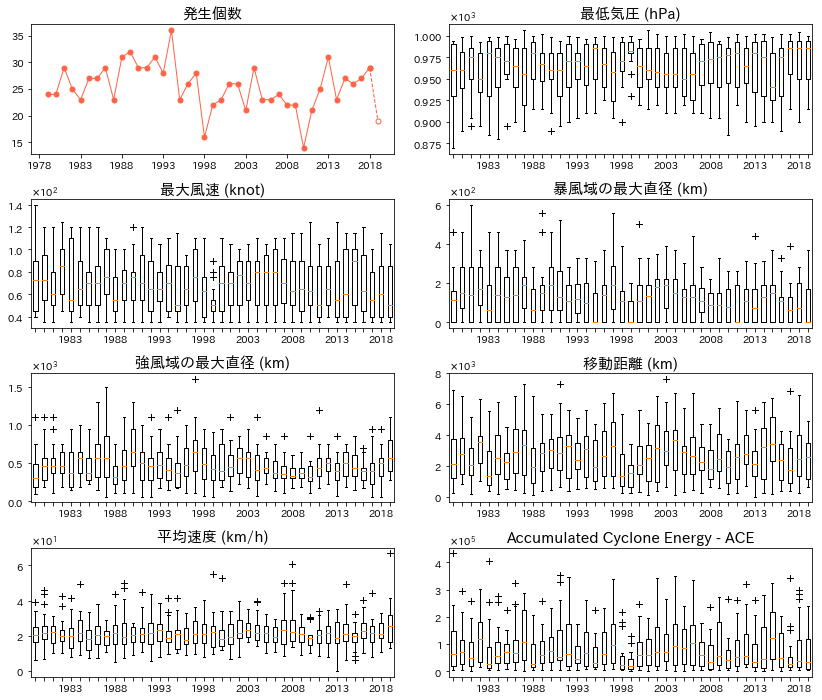

In [16]:
fig = plt.figure(figsize=(14,12))
plt.subplots_adjust(hspace=0.35,wspace=0.15)
titles =['最低気圧 (hPa)','最大風速 (knot)','暴風域の最大直径 (km)','強風域の最大直径 (km)',
         '移動距離 (km)', '平均速度 (km/h)','Accumulated Cyclone Energy - ACE']

ax = fig.add_subplot(4,2,1)
amounts = GetBinsData('amount', dataset_lim)
y = year_range[1:]
ax.set_title('発生個数',fontsize=15)
ax.plot(y[-2:],[np.mean(i) for i in amounts][-2:],lw=1,color='tomato',markeredgecolor='tomato',
        ms=5,marker='o',ls='--',markerfacecolor='white')
ax.plot(y[:-1],[np.mean(i) for i in amounts][:-1],lw=1,color='tomato',ms=5,marker='o')
ax.set_xticks(np.arange(1978,2020,5))

y = [str(i) if i in np.arange(1978,2020,5).astype(np.uint32) else ' ' for i in year_range[1:]]

for n,a in enumerate(attrs_list):
    ax = fig.add_subplot(4,2,n+2)
    ax.boxplot(GetBinsData(a,dataset_lim),sym='+')
    ax.set_xticklabels(y)
    ax.set_title(titles[n],fontsize=15)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))

### 台風の経路情報を読み込み、整形

In [6]:
url = 'https://raw.githubusercontent.com/dataofjapan/land/master/japan.geojson'
response = urllib.request.urlopen(url)
jpn_geojson = json.loads(response.read().decode('utf8'))

In [7]:
year_range = np.arange(1978,2020,1)
typhoon_json = []
for y in year_range:
    path = glob.glob('typhoon/'+str(y)+'/*.json')
    jsons = []
    for p in path:
        f = open(p,'r')
        sample = json.load(f)
        jsons.append(sample)
    typhoon_json.append(jsons)
f.close()

### 2019年に発生したすべての台風の経路を表示 

In [17]:
names = [i['properties']['nam_ja'] for i in jpn_geojson['features']]

coordinates = []
for n in range(len(names)):
    coordinates.append(jpn_geojson['features'][n]['geometry']['coordinates'])

target = 2019
num = np.where(year_range == target)[0][0]
routes = []
for t in typhoon_json[num]:
    hoge = np.array([i['geometry']['coordinates'] for i in t['features']])
    routes.append(hoge)

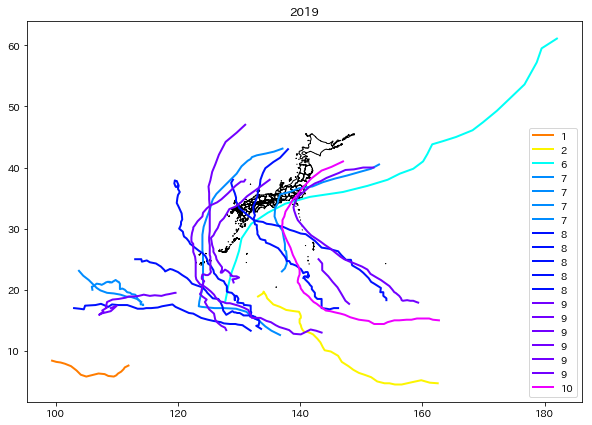

In [18]:
fig = plt.figure(figsize=(10,7))
polygons = []
prefectures = []

for n in range(47):
# print(coordinates[n][0])
    plt.title(year_range[num],fontsize=16)
    c = coordinates[n]
    for i in c:
        if(len(c) == 1):
            h = np.array(i)
        else:
            h = np.array(i)[0]
        plt.plot(h[:,0],h[:,1],c='black',lw=1)
        polygons.append(Polygon(h))
        prefectures.append(names[n])
    plt.gca().set_aspect('equal')

for n,r in enumerate(routes):
    colors = [int(i['birth'].month) for i in dic_array[str(target)]]
    plt.plot(r[:,0],r[:,1],lw=2,ms=4,c=cm.hsv(colors[n]/12),label=colors[n])

# plt.xlim(120,160)
# plt.ylim(25,50)

plt.legend()

### 台風の上陸情報を取得

In [13]:
year_range = np.arange(1978,2020,1)
for year in tqdm(year_range):
    
    path = glob.glob('typhoon/'+str(year)+'/*.json')
    jsons = []
    for p in path:
        f = open(p,'r',encoding="utf-8_sig")
        sample = json.load(f)
        jsons.append(sample)
    f.close()
    
    for n, (dic, js) in enumerate(zip(dic_array[str(year)], jsons)):
        route = np.array([i['geometry']['coordinates'] for i in js['features']])
        route_points = []
        for pt in route:
            point = Point(pt[0],pt[1])
            route_points.append(point)
        
        isLanding = False
        LandingAreas = []
        for point in route_points:
            for m,polygon in enumerate(polygons):
                dec = polygon.contains(point)
                if(dec):
                    isLanding = True
                    LandingAreas.append(prefectures[m])
                    
                    
        dic_array[str(year)][n]['isLanding'] = isLanding
        dic_array[str(year)][n]['LandingAreas'] = LandingAreas

### 日本に到達した台風だけに絞ってデータを表示

In [19]:
year_range = np.arange(1978,2020,1)
attrs_list = ['pressure','wind_velocity','area1','area2','moving',
              'mean_velocity','ACE']
dataset_lim = []
range_list = []
for n in range(year_range.shape[0]-1):
    range_ = np.linspace(year_range[n]+1,year_range[n+1],5)
    range_list.append(range_.astype(np.uint32))
    name = str(int(range_[0]))+'-'+str(int(range_[-1]))
    attrs = {'pressure':[], 'wind_velocity':[], 'area1':[],
                'area2':[], 'moving':[], 'mean_velocity':[],
                'ACE':[],'amount':[]}
    for y in range_:
        typhoon_list = dic_array[str(int(y))]
        amo = 0
        for t in typhoon_list:
            if(t['isLanding']):
                amo += 1
                for a in attrs_list:
                    attrs[a].append(t[a])
            else:
                pass
        attrs['amount'].append(amo)
    
    dataset_lim.append(attrs)

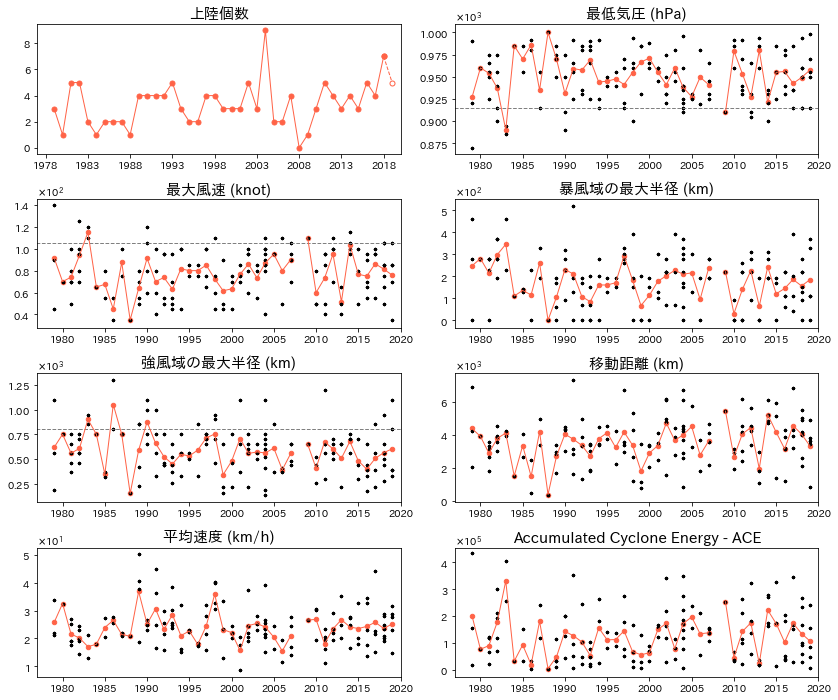

In [21]:
fig = plt.figure(figsize=(14,12))
plt.subplots_adjust(hspace=0.35,wspace=0.15)
titles =['最低気圧 (hPa)','最大風速 (knot)','暴風域の最大半径 (km)','強風域の最大半径 (km)',
         '移動距離 (km)', '平均速度 (km/h)','Accumulated Cyclone Energy - ACE']

ax = fig.add_subplot(4,2,1)
amounts = GetBinsData('amount', dataset_lim)
y = year_range[1:]
ax.set_title('上陸個数',fontsize=15)
ax.plot(y[-2:],[np.mean(i) for i in amounts][-2:],lw=1,color='tomato',markeredgecolor='tomato',
        ms=5,marker='o',ls='--',markerfacecolor='white')
ax.plot(y[:-1],[np.mean(i) for i in amounts][:-1],lw=1,color='tomato',ms=5,marker='o')
ax.set_xticks(np.arange(1978,2020,5))
ax.set_xlim(1977,2020)


y = year_range[1:]

for m,a in enumerate(attrs_list):
    ax = fig.add_subplot(4,2,m+2)
    if(m == 0):
        yline = np.arange(1970,2030,1)
        ax.plot(yline,[915 for i in yline],ls='--',lw=1,c='gray')
    if(m == 1):
        yline = np.arange(1970,2030,1)
        ax.plot(yline,[105 for i in yline],ls='--',lw=1,c='gray')
    if(m == 3):
        yline = np.arange(1970,2030,1)
        ax.plot(yline,[800 for i in yline],ls='--',lw=1,c='gray')
    data = GetBinsData(a,dataset_lim)
    means = []
    for n,d in enumerate(data):
        if(len(d) != 0):
            mean = np.mean(np.array(d))
            ax.scatter(y[n],mean,color='tomato',s=20)
            ax.scatter([y[n] for i in d], d, s=5,c='black')
            means.append(mean)
        else:
            means.append(np.nan)
    ax.set_xlim(1977,2020)
    ax.plot(y,means,c='tomato',lw=1)
    ax.set_title(titles[m],fontsize=15)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))

### 海面水温平年差のデータと合わせて表示

In [22]:
npac_data = np.loadtxt('./typhoon/npac.txt')

No handles with labels found to put in legend.


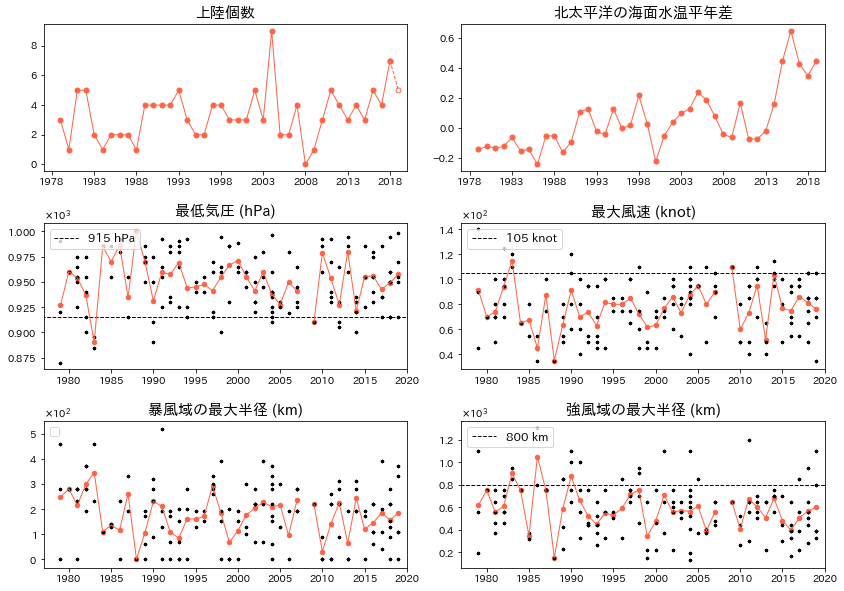

In [23]:
fig = plt.figure(figsize=(14,10))
plt.subplots_adjust(hspace=0.35,wspace=0.15)
titles =['最低気圧 (hPa)','最大風速 (knot)','暴風域の最大半径 (km)','強風域の最大半径 (km)']
attrs_list = ['pressure','wind_velocity','area1','area2']

ax = fig.add_subplot(3,2,1)
amounts = GetBinsData('amount', dataset_lim)
y = year_range[1:]
ax.set_title('上陸個数',fontsize=15)
ax.plot(y[-2:],[np.mean(i) for i in amounts][-2:],lw=1,color='tomato',markeredgecolor='tomato',
        ms=5,marker='o',ls='--',markerfacecolor='white')
ax.plot(y[:-1],[np.mean(i) for i in amounts][:-1],lw=1,color='tomato',ms=5,marker='o')
ax.set_xticks(np.arange(1978,2020,5))
ax.set_xlim(1977,2020)

ax = fig.add_subplot(3,2,2)
amounts = GetBinsData('amount', dataset_lim)
y = year_range[1:]
ax.set_title('北太平洋の海面水温平年差',fontsize=15)
ax.plot(y,npac_data[87:,1],lw=1,color='tomato',ms=5,marker='o')
ax.set_xticks(np.arange(1978,2020,5))
ax.set_xlim(1977,2020)


y = year_range[1:]

for m,a in enumerate(attrs_list):
    ax = fig.add_subplot(3,2,m+3)
    if(m == 0):
        yline = np.arange(1970,2030,1)
        ax.plot(yline,[915 for i in yline],ls='--',lw=1,c='black',label='915 hPa')
    if(m == 1):
        yline = np.arange(1970,2030,1)
        ax.plot(yline,[105 for i in yline],ls='--',lw=1,c='black',label='105 knot')
    if(m == 3):
        yline = np.arange(1970,2030,1)
        ax.plot(yline,[800 for i in yline],ls='--',lw=1,c='black',label='800 km')
    data = GetBinsData(a,dataset_lim)
    means = []
    plt.legend(loc = 'upper left',fontsize=12)
    for n,d in enumerate(data):
        if(len(d) != 0):
            mean = np.mean(np.array(d))
            ax.scatter(y[n],mean,color='tomato',s=20)
            ax.scatter([y[n] for i in d], d, s=5,c='black')
            means.append(mean)
        else:
            means.append(np.nan)
    ax.set_xlim(1977,2020)
    ax.plot(y,means,c='tomato',lw=1)
    ax.set_title(titles[m],fontsize=15)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))

### 台風の経路情報を年代別に可視化

In [24]:
year_bins = np.linspace(2004,2019,16).astype(np.uint(32))
year_bins = list(year_bins)[::-1]

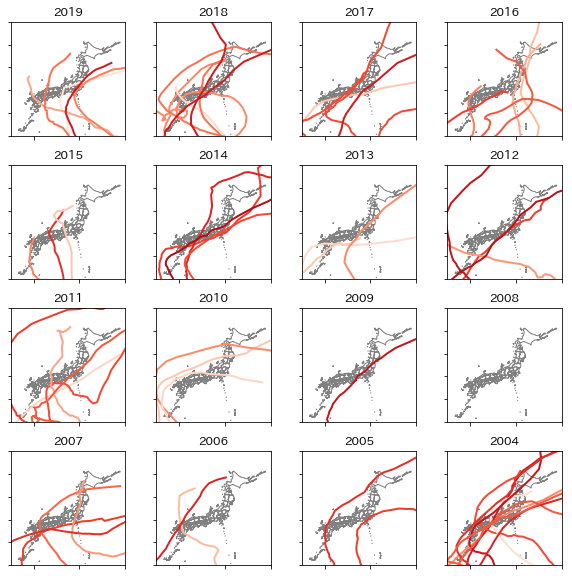

In [25]:
fig = plt.figure(figsize=(10,10))

cn = 0
plt.subplots_adjust(hspace=0.25)
for y in tqdm(year_bins):
    
    plt.subplot(4,4, cn+1)
    plt.title(y,fontsize=12)
    for n in range(47):
        c = coordinates[n]
        for i in c:
            if(len(c) == 1):
                h = np.array(i)
            else:
                h = np.array(i)[0]
            plt.plot(h[:,0],h[:,1],c='gray',lw=1)
        plt.gca().set_aspect('equal')
    
    num = np.where(year_range == y)[0][0]
    routes = []
    for t in typhoon_json[num]:
        hoge = np.array([i['geometry']['coordinates'] for i in t['features']])
        routes.append(hoge)

    isLanding = [i['isLanding'] for i in dic_array[str(int(y))]]
    colors = [(i['pressure'] - 880)/(1013 - 880) for i in dic_array[str(y)]]

    for n,r in enumerate(routes):
        if(isLanding[n] is True):
            plt.plot(r[:,0],r[:,1],lw=2,ms=4,
                    c=cm.Reds_r(colors[n]))
                
    cn += 1
    plt.xlim(125,150)
    plt.ylim(25,50)
    plt.tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)

In [26]:
year_bins = np.linspace(1987,2003,16).astype(np.uint(32))
year_bins = list(year_bins)[::-1]

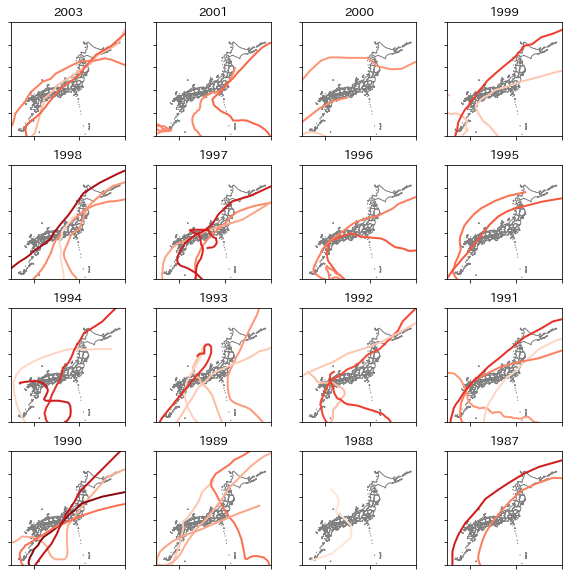

In [27]:
fig = plt.figure(figsize=(10,10))

cn = 0
plt.subplots_adjust(hspace=0.25)
for y in tqdm(year_bins):
    
    plt.subplot(4,4, cn+1)
    plt.title(y,fontsize=12)
    for n in range(47):
        c = coordinates[n]
        for i in c:
            if(len(c) == 1):
                h = np.array(i)
            else:
                h = np.array(i)[0]
            plt.plot(h[:,0],h[:,1],c='gray',lw=1)
        plt.gca().set_aspect('equal')
    
    num = np.where(year_range == y)[0][0]
    routes = []
    for t in typhoon_json[num]:
        hoge = np.array([i['geometry']['coordinates'] for i in t['features']])
        routes.append(hoge)

    isLanding = [i['isLanding'] for i in dic_array[str(int(y))]]
    colors = [(i['pressure'] - 880)/(1013 - 880) for i in dic_array[str(y)]]

    for n,r in enumerate(routes):
        if(isLanding[n] is True):
            plt.plot(r[:,0],r[:,1],lw=2,ms=4,
                    c=cm.Reds_r(colors[n]))        
    cn += 1
    plt.xlim(125,150)
    plt.ylim(25,50)
    plt.tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)